<a href="https://colab.research.google.com/github/JulienGremillot/codelab_machine_learning/blob/main/Codelab_Classification_d'images_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

On récupère le jeu de données "[Hotdog NotHotdog](https://www.kaggle.com/yashvrdnjain/hotdognothotdog)", disponible sur Kaggle ou sur mon drive à l'URL précisée dans le code.

In [1]:
import requests
from tqdm import tqdm
URL = "https://drive.google.com/uc?export=download"
id = "1pPl16WK_txBH-STO5v9sTbP6xfuxqbin"

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value
    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768
    with open(destination, "wb") as f:
        with tqdm(unit='B', unit_scale=True, unit_divisor=1024) as bar:
            for chunk in response.iter_content(CHUNK_SIZE):
                if chunk:  # filter out keep-alive new chunks
                    f.write(chunk)
                    bar.update(CHUNK_SIZE)

session = requests.Session()
response = session.get(URL, params = { 'id' : id }, stream = True)
token = get_confirm_token(response)

if token:
    params = { 'id' : id, 'confirm' : token }
    response = session.get(URL, params = params, stream = True)

save_response_content(response, "hotdog-nothotdog.zip")    

166MB [00:01, 149MB/s]


On décompresse le fichier ZIP

In [2]:
dataset_dir = "hotdog-nothotdog"
width, height = 224, 224
import zipfile
with zipfile.ZipFile('hotdog-nothotdog.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

On affiche quelques images du dataset

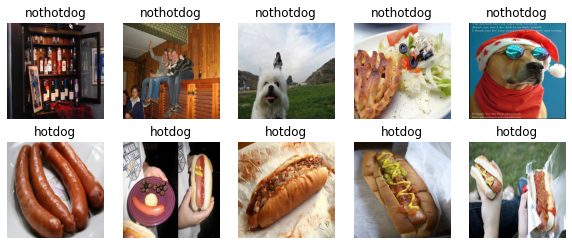

In [3]:
# Lecture des images du dataset
import os
from PIL import Image
import matplotlib.pyplot as plt

train_dir = os.path.join(dataset_dir, 'train')
plt.figure(figsize=(10,4))
i = 1
for sub_dir in os.listdir(train_dir):
    sub_dir_images = os.listdir(os.path.join(train_dir, sub_dir))
    j = 0
    for sub_dir_image in sub_dir_images:
        if i <= 10 and j < 5:
            image = os.path.join(train_dir, sub_dir, sub_dir_image)
            img = Image.open(image) 
            img_resized = img.resize((width, height))
            plt.subplot(2, 5, i)
            plt.axis('off')
            plt.title(sub_dir)
            plt.imshow(img_resized)
            i = i + 1
            j = j + 1
plt.show()

On va maintenant tester un modèle ViT pré-entrainé par Google, mis à disposition sur le site HuggingFace : https://huggingface.co/google/vit-base-patch16-224-in21k

In [4]:
pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 67 kB 3.7 MB/s 
     |████████████████████████████████| 6.8 MB 28.3 MB/s 
     |████████████████████████████████| 895 kB 42.6 MB/s 
     |████████████████████████████████| 596 kB 49.4 MB/s 


In [5]:
from transformers import ViTFeatureExtractor, ViTForImageClassification
google_vit_model = 'google/vit-base-patch16-224'
feature_extractor = ViTFeatureExtractor.from_pretrained(google_vit_model)
model = ViTForImageClassification.from_pretrained(google_vit_model)

Downloading:   0%|          | 0.00/160 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/68.0k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/330M [00:00<?, ?B/s]

In [6]:
try:
    import hugsvision
except:
    !pip install -q hugsvision
    import hugsvision
    
print(hugsvision.__version__)

     |████████████████████████████████| 397 kB 15.4 MB/s 
     |████████████████████████████████| 431 kB 48.9 MB/s 
     |████████████████████████████████| 527 kB 40.0 MB/s 
     |████████████████████████████████| 952 kB 40.7 MB/s 
     |████████████████████████████████| 829 kB 43.0 MB/s 
     |████████████████████████████████| 133 kB 47.4 MB/s 
     |████████████████████████████████| 1.1 MB 42.3 MB/s 
     |████████████████████████████████| 271 kB 36.2 MB/s 
     |████████████████████████████████| 144 kB 39.6 MB/s 
     |████████████████████████████████| 94 kB 2.5 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


0.75.3


In [7]:
from hugsvision.dataio.VisionDataset import VisionDataset

train, test, id2label, label2id = VisionDataset.fromImageFolder(
	train_dir,
	test_ratio   = 0.2,
	balanced     = True,
	augmentation = True
)

Split Datasets...
Balance train dataset...
The less represented label in train as 1500 occurrences
Size of train after balancing is 3000
train_ds:  2400
+---------+--------+-----------+-------+
| Dataset | hotdog | nothotdog | Total |
+---------+--------+-----------+-------+
|  Train  |  1191  |   1209    | 2400  |
|  Test   |  309   |    291    |  600  |
+---------+--------+-----------+-------+


In [8]:
from hugsvision.nnet.VisionClassifierTrainer import VisionClassifierTrainer
google_vit_model = 'google/vit-base-patch16-224-in21k'

model = ViTForImageClassification.from_pretrained(
    google_vit_model,
    num_labels=len(label2id),
    label2id=label2id,
    id2label=id2label
)

feature_extractor = ViTFeatureExtractor.from_pretrained(
    google_vit_model
)

trainer = VisionClassifierTrainer(
    model_name="HotdogNotHotdogModel",
    train=train,
    test=test,
    output_dir="./out/",
    max_epochs=5,
    batch_size=32,
    lr=2e-5,
    fp16=True,
    model=model,
    feature_extractor=feature_extractor
)

Downloading:   0%|          | 0.00/502 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/330M [00:00<?, ?B/s]

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Downloading:   0%|          | 0.00/160 [00:00<?, ?B/s]

{'0': 'hotdog', '1': 'nothotdog'}
{'hotdog': '0', 'nothotdog': '1'}


Using amp half precision backend
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 2400
  Num Epochs = 5
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 375


Trainer builded!
Start Training!


Epoch,Training Loss,Validation Loss
1,No log,0.162807
2,No log,0.088429
3,No log,0.080961
4,No log,0.078129
5,No log,0.079741


***** Running Evaluation *****
  Num examples = 600
  Batch size = 32
***** Running Evaluation *****
  Num examples = 600
  Batch size = 32
***** Running Evaluation *****
  Num examples = 600
  Batch size = 32
***** Running Evaluation *****
  Num examples = 600
  Batch size = 32
***** Running Evaluation *****
  Num examples = 600
  Batch size = 32


Training completed. Do not forget to share your model on huggingface.co/models =)


Saving model checkpoint to ./out/HOTDOGNOTHOTDOGMODEL/5_2022-02-15-08-35-37/trainer/
Configuration saved in ./out/HOTDOGNOTHOTDOGMODEL/5_2022-02-15-08-35-37/trainer/config.json
Model weights saved in ./out/HOTDOGNOTHOTDOGMODEL/5_2022-02-15-08-35-37/trainer/pytorch_model.bin
Configuration saved in ./out/HOTDOGNOTHOTDOGMODEL/5_2022-02-15-08-35-37/model/config.json
Model weights saved in ./out/HOTDOGNOTHOTDOGMODEL/5_2022-02-15-08-35-37/model/pytorch_model.bin
Feature extractor saved in ./out/HOTDOGNOTHOTDOGMODEL/5_2022-02-15-08-35-37/feature_extractor/preproces

Model saved at: ./out/HOTDOGNOTHOTDOGMODEL/5_2022-02-15-08-35-37


In [9]:
hyp, ref = trainer.evaluate_f1_score()

100%|██████████| 600/600 [00:30<00:00, 19.50it/s]

              precision    recall  f1-score   support

      hotdog     0.9836    0.9709    0.9772       309
   nothotdog     0.9695    0.9828    0.9761       291

    accuracy                         0.9767       600
   macro avg     0.9765    0.9768    0.9767       600
weighted avg     0.9768    0.9767    0.9767       600

Logs saved at: ./out/HOTDOGNOTHOTDOGMODEL/5_2022-02-15-08-35-37


loading feature extractor configuration file ./out/HOTDOGNOTHOTDOGMODEL/5_2022-02-15-08-35-37/model/preprocessor_config.json
Feature extractor ViTFeatureExtractor {
  "_name_or_path": "google/vit-base-patch16-224-in21k",
  "architectures": [
    "ViTForImageClassification"
  ],
  "attention_probs_dropout_prob": 0.0,
  "do_normalize": true,
  "do_resize": true,
  "feature_extractor_type": "ViTFeatureExtractor",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "hotdog",
    "1": "nothotdog"
  },
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_size": 224,
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "hotdog": "0",
    "nothotdog": "1"
  },
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": true,
  "resample": 2,
  "size": 224,
  "torch_dtyp

Model loaded!
Predicted class: hotdog


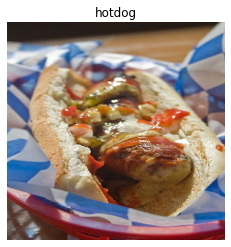

In [10]:
from hugsvision.inference.VisionClassifierInference import VisionClassifierInference
from shutil import copyfile
import matplotlib.pyplot as plt
import os

path_prefix = "./out/HOTDOGNOTHOTDOGMODEL"
path_suffix = "model"
path_model_dir = os.listdir(path_prefix)[0]
path = os.path.join(path_prefix, path_model_dir, path_suffix)
src = os.path.join(path, 'config.json')
dst = os.path.join(path, 'preprocessor_config.json')
copyfile(src, dst)

class_dir = os.path.join(dataset_dir, 'test', 'hotdog')
image_name = os.listdir(class_dir)[0]
image_path = os.path.join(class_dir, image_name)
image = Image.open(image_path)
plt.title('hotdog')
plt.imshow(image)
plt.axis("off")

classifier = VisionClassifierInference(
    feature_extractor = ViTFeatureExtractor.from_pretrained(path),
    model = ViTForImageClassification.from_pretrained(path),
)

label = classifier.predict(img_path=image_path)
print("Predicted class:", label)


OKs : 10 KOs : 0 Pourcentage OK : 100 %


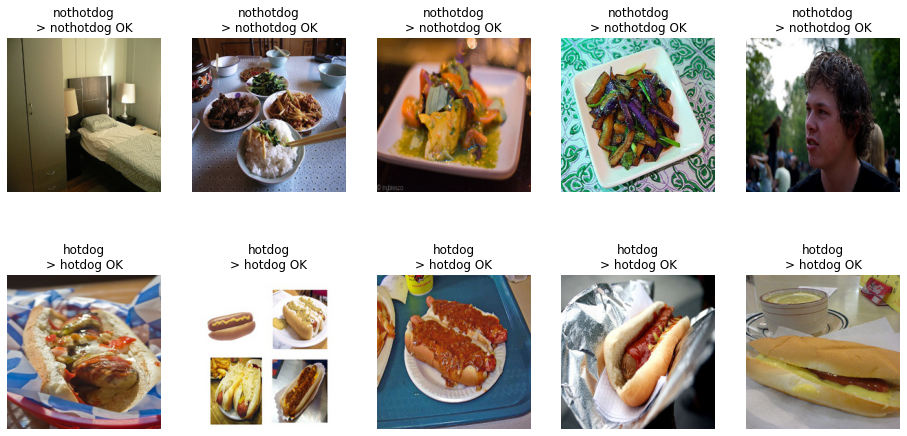

In [11]:
import numpy as np

test_dir = os.path.join(dataset_dir, 'test')
plt.figure(figsize=(16, 8))
i = 1
j = 0
oks = 0
kos = 0
for sub_dir in os.listdir(test_dir):
    hotdog_images = os.listdir(os.path.join(test_dir, sub_dir))
    for hotdog_image in hotdog_images:
        if i <= 5:
            img_path = os.path.join(test_dir, sub_dir, hotdog_image)
            img = Image.open(img_path)
            img_resized = img.resize((width, height))
            plt.subplot(2, 5, i + j * 5)
            plt.axis('off')
            prediction = classifier.predict(img_path=img_path)
            title = sub_dir + '\n> ' + prediction
            if sub_dir == prediction:
              title += " OK"
              oks += 1
            else:
              title += " KO"
              kos += 1
            plt.title(title)
            plt.imshow(img_resized)
            i += 1
    i = 1
    j += 1
plt.show()
print("\nOKs :", oks, "KOs :", kos, 
      "Pourcentage OK :", round(oks * 100 / (oks + kos)), "%")
  